<h1 align = 'center'>Breaking Bad : Network Analysis</h1>

<img src = 'src/imgs/Breaking_Bad_Cast.jpg' width = 90%>

- In this part we are analyzing the Breaking Bad series with the help of [spaCy](https://spacy.io/), [NetworkX](https://networkx.org/) and [pyvis](https://pyvis.readthedocs.io/en/latest/index.html).
- As part of this section, we will use [spaCy](https://spacy.io/) for [Named Entity Recognition (NER)](https://www.geeksforgeeks.org/named-entity-recognition/) for to exteact out the character names from the scrapped text files.
- Then we will define our own rule for how to generate relationship using this NER data.
- Once we have the cooked relationship data, using [NetworkX](https://networkx.org/) we will perform network analysis.
- For the analysis we will use centrality measurement tools like degree centrality, closeness centrality, betweenness centrality, pagerank etc. in our network.
- The target is to find out the most importance characters in each season.
<br><br><br>
<div style="text-align:center;">
<!-- <a href = 'https://github.com/jishnukoliyadan/the_breaking_bad_network' target = '_blank'><img src = 'https://raw.githubusercontent.com/jishnukoliyadan/usefull_items/master/svgs/GitHub_View_Source.svg' width =18%></a>
<a href = 'https://nbviewer.org/github/jishnukoliyadan/the_breaking_bad_network/blob/master/Relationship_Finder.ipynb' target = '_blank'><img src = 'https://raw.githubusercontent.com/jishnukoliyadan/usefull_items/master/svgs/NbViwer_View_In.svg' width =18%></a>

<a href = 'https://colab.research.google.com/github/jishnukoliyadan/the_breaking_bad_network/blob/master/Relationship_Finder.ipynb' target = '_blank'><img src = 'https://raw.githubusercontent.com/jishnukoliyadan/usefull_items/master/svgs/Colab_Run_In.svg' width =18%></a>
<a href = 'https://www.kaggle.com/code/jishnukoliyadan/relationship-finder-network-analysis' target = '_blank'><img src = 'https://raw.githubusercontent.com/jishnukoliyadan/usefull_items/master/svgs/Kaggle_View_On.svg' width =18%></a> -->
</div><br>

**NOTE :**

- For those who already spent time to watch the series know *Walter White* is the most important character.
- The idea of this project is to validate our watching experience **and proving it with datapoints **, and justify how powerful *Walter White* is throughout the series.

# 1. Importing libraries & creating working paths

In [2]:
import re
import os

import glob

import spacy
from spacy import displacy

import pandas as pd
import seaborn as sns

import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import networkx as nx
from pyvis.network import Network
import community

In [3]:
!python3 -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Setting plot styles

plt.style.use(['fivethirtyeight', 'src/plt_style'])

In [5]:
# Creating directories for storing files

os.makedirs('src/htmls', exist_ok = True)
os.makedirs('src/plots', exist_ok = True)
os.makedirs('src/char_imp', exist_ok = True)
os.makedirs('data/gephi_files', exist_ok = True)

# 2. Loading dataset for example

1. We are importing one of the summaries and exploring that with the help of **Spacy**'s Named Entity Recognition (NER) technique.
2. Extracting out and storing named entities from all the sentences to a list and store to a *dataframe*.
3. Filter the named entity list based on character names using `character_df_cleaned.csv` we have.
4. Filter the *dataframe* again based on the the entity list based on *length* of the list.
5. Using this cleaned entity list generating relationships based on the criterion.

## 2.1 Loading data

In [6]:
character_df = pd.read_csv('data/character_df_cleaned.csv')
character_df.head()

,Season,Characters
0,Season_1,Walter White
1,Season_1,Skyler White
2,Season_1,Jesse Pinkman
3,Season_1,Hank Schrader
4,Season_1,Marie Schrader


In [7]:
# Loading spaCy English language model

NER = spacy.load('en_core_web_sm')

In [8]:
# Reading season summary file

with open('data/summaries/Season_1.txt', 'r') as f:
    sea1_txt = f.read()

sea1_txt = sea1_txt.replace('\n', '\n. ')

In [9]:
# https://stackoverflow.com/a/51219483
# https://nanonets.com/blog/named-entity-recognition-with-nltk-and-spacy/ : For NLTK

ner1 = NER(sea1_txt)

# Visualize the identidied entites

displacy.render(ner1[:500], style = 'ent', jupyter = True)

## 2.2 Extracting and storing named entities.

In [10]:
# Looping through the sentences to create entity list and dataframe

entity_df = []

for sentence in ner1.sents:
    entity_lis = [ent.text for ent in sentence.ents]
    entity_df.append({'sentence' : sentence, 'entities' : entity_lis})
    
entity_df = pd.DataFrame(entity_df)


## 2.3 Filtering entities based on `character_df`

In [11]:
def rename_names(name):
    
    '''
    Changes name "Walter White Jr." to "Walt Jr."
    
    Input & Return :
      - string : name
    '''
    
    if name == 'Walter White Jr.':
        return re.sub(name, 'Walt Jr.', name)
    return name

In [12]:
# Extracting firstname and lastname and adding as new columns

character_df.Characters = character_df.Characters.apply(rename_names)
character_df['Characters_firstname'] = character_df.Characters.apply(lambda x : re.sub(r"'s", '', x.split()[0]))
character_df['Characters_lastname'] = character_df.Characters.apply(lambda x : re.sub(r"'s", '', x.split()[-1]))

character_df.head()

,Season,Characters,Characters_firstname,Characters_lastname
0,Season_1,Walter White,Walter,White
1,Season_1,Skyler White,Skyler,White
2,Season_1,Jesse Pinkman,Jesse,Pinkman
3,Season_1,Hank Schrader,Hank,Schrader
4,Season_1,Marie Schrader,Marie,Schrader


In [13]:
def filter_entities(entity_list, char_df):
    
    '''
    Adding only the entities present in the character dataframe which are common with the entities found by NER.
     
    Input :
      - list : entity_list
      - pandas dataframe : char_df
    Retuen :
      - list : 
    '''
    
    return [entity for entity in entity_list
            if entity in list(char_df.Characters)
            or entity in list(char_df.Characters_firstname)
            or entity in list(char_df.Characters_lastname)]

In [14]:
# Calling 'filter_entities()' to filter the entites only to character names from character_df

entity_df['char_entities'] = entity_df.entities.apply(lambda x: filter_entities(x, character_df))
entity_df.head(10)

,sentence,entities,char_entities
0,"(Walter, is, recording, a, farewell, to, his, ...",[Walter],[Walter]
1,"(In, the, New, Mexico, desert, ,, a, man, wear...","[New Mexico, RV]",[]
2,"(In, the, passenger, seat, ,, another, man, is...",[],[]
3,"(In, the, back, of, the, RV, are, two, bodies, .)","[RV, two]",[]
4,"(After, crashing, the, RV, in, a, ditch, ,, th...",[RV],[]
5,"(Recording, a, message, on, the, camcorder, ,,...",[Walter White],[Walter White]
6,"(Sirens, are, heard, in, the, distance, .)",[],[]
7,"(Walt, walks, onto, the, road, and, awaits, th...",[Walt],[Walt]
8,"(Veggie, bacon, for, Walt, 's, 50th, birthday,...","[Veggie, Walt, 50th]",[Walt]
9,"(Three, weeks, earlier, ,, it, is, Walt, 's, 5...","[Three weeks earlier, Walt, 50th]",[Walt]


## 2.4 Filter the `entity_df` based on `char_entities` length

In [15]:
# Filtering dataframe : Selecting only rows with atleast one entity

entity_df = entity_df[entity_df['char_entities'].map(len) > 0]
entity_df.reset_index(inplace = True, drop = True)
entity_df.head()

,sentence,entities,char_entities
0,"(Walter, is, recording, a, farewell, to, his, ...",[Walter],[Walter]
1,"(Recording, a, message, on, the, camcorder, ,,...",[Walter White],[Walter White]
2,"(Walt, walks, onto, the, road, and, awaits, th...",[Walt],[Walt]
3,"(Veggie, bacon, for, Walt, 's, 50th, birthday,...","[Veggie, Walt, 50th]",[Walt]
4,"(Three, weeks, earlier, ,, it, is, Walt, 's, 5...","[Three weeks earlier, Walt, 50th]",[Walt]


In [16]:
def name_correction(name):
    
    '''
    Takes input string and return a unique name based on the conditions.
    Names some times mentioned as first name, second name and some times
    as full name. This funtion helps to maintain unique name.
    Some identified names are included in this funtion, to make more robust,
    we can add more names and conditions here.
     
    Imput and Return :
      - string : name
    '''
    
    if name == 'Elliot' or name == 'Elliott Schwartz' or name == 'Schwartz':
        return 'Elliott'
    
    if name == 'Gretchen Schwartz':
        return 'Gretchen'
    
    if name == 'Gale' or name == 'Boetticher':
        return 'Gale Boetticher'
        
    if name == 'Gus' or name == 'Gustavo Fring' or name in "Gus'":
        return 'Gus Fring'
        
    if name == 'Saul' or name == 'Goodman':
        return 'Saul Goodman'
    
    if name == 'Schrader' or name == 'Hank Schrader':
        return 'Hank'
    
    if name == 'Jesse Pinkman' or name == 'Pinkman':
        return 'Jesse'
    
    if name == 'Mike Ehrmantraut' or name == 'Ehrmantraut':
        return 'Mike'
    
    if name == 'Walter White' or name == 'White' or name == 'Whites' or name == 'Walt':
        return 'Walter'
    
    if name == 'Skyler White':
        return 'Skyler'
    
    if name == 'Tuco':
        return 'Tuco Salamanca'

    if name == 'ASAC' or name == 'George Merkert':
        return 'ASAC George Merkert'

    if name == 'Donald':
        return 'Donald Margolis'
    
    if name == 'Jane':
        return 'Jane Margolis'

    if name == 'Hector':
        return 'Hector Salamanca'
    
    if name == 'APD':
        return 'DEA'
 
    if name == 'Ted' or name == 'Beneke':
        return 'Ted Beneke'
    
    if name in "Jimmy In-'N-Out":
        return 'Jimmy'

    if name == 'Andrea' or name == 'Cantillo':
        return 'Andrea Cantillo'
 
    if name == 'Leonel':
        return 'Leonel Salamanca'

    if name == 'Huell' or name == 'Babineaux':
        return 'Huell Babineaux'
 
    if name == 'Tyrus':
        return 'Tyrus Kitt'
    
    if name == 'Marie Schrader':
        return 'Marie'
 
    if name == 'Max' or name == 'Arciniega':
        return 'Max Arciniega'
    
    if name == 'Dennis':
        return 'Dennis Markowski'
    
    if name == 'Dan':
        return 'Dan Wachsberger'
    
    if name == 'Jack':
        return 'Jack Welker'
    
    if name == 'Todd':
        return 'Todd Alquist'
    
    if name in 'Lydia Rodarte-Quayle':
        return 'Lydia'
    
    if name == 'Peter':
        return 'Peter Schuler'    
    
    return name

## 2.5 Generating relationships

<img src = 'src/imgs/relationship_example.gif' width = 80%>

**Example on generating relationships :**

- We will define a `window_size` of 5.
- We'll combine all the character name entities in those list and creates `char_list`.

```python
char_list   = ['Walter', 'Jesse', 'Walter', 'Jesse', 'Walter', 'Walter', 'Jesse', 'Gomez', 'Hank', 'Walter', 'Walter']
unique_char = ['Walter', 'Jesse', 'Walter', 'Jesse', 'Walter', 'Jesse', 'Gomez', 'Hank', 'Walter']
```

- In this exapmle in `char_list`, in comparing item 5 & 6, both are same. So skipping similar items like this.
- Otherwise retaining those elements and creates another list `unique_char`.
- Now we'll iterate through this `unique_char` until second last character to generate relationships.
    - While iterating 1st item will get recorded as `source` and 2nd item as `destination`.

In [17]:
# Generating relatinships from a window_size of 5

relationship = []

for idx in range(entity_df.shape[0]):
    
    window_size = 5
    e_idx = min(idx+window_size, entity_df.shape[0])
    char_list = sum(entity_df.loc[idx:e_idx].char_entities, [])
    char_list = list(map(name_correction, char_list))
    
    # To remove same characters, if they are close to each other
    unique_char = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]
    
    if idx % 220 == 0:
        print(char_list)
        print(unique_char)
        print('\n')

    if len(unique_char) > 1:
        for idx, a in enumerate(unique_char[:-1]):
            b = unique_char[idx + 1]
            relationship.append({'Source' : a, 'Destination' : b})

['Walter', 'Walter', 'Walter', 'Walter', 'Walter', 'Albuquerque', 'Walter']
['Walter', 'Albuquerque', 'Walter']


['Walter', 'Elliott', 'Walter', 'Walter', 'Hugo', 'Skyler', 'Walter', 'Walter', 'Walter']
['Walter', 'Elliott', 'Walter', 'Hugo', 'Skyler', 'Walter']




In [18]:
relationship_df = pd.DataFrame(relationship)
print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")

relationship_df.head(20)

Shape of dataset 'relationship_df' :: (2342, 2)



,Source,Destination
0,Walter,Albuquerque
1,Albuquerque,Walter
2,Walter,Albuquerque
3,Albuquerque,Walter
4,Walter,Skyler
5,Walter,Albuquerque
6,Albuquerque,Walter
7,Walter,Skyler
8,Skyler,Walt Jr.
9,Walter,Albuquerque


In [19]:
# Calculating strength of the character bond

relationship_df['value'] = 1
relationship_df = relationship_df.groupby(['Source', 'Destination'], sort=False, as_index=False).sum()
relationship_df.head(10)

,Source,Destination,value
0,Walter,Albuquerque,5
1,Albuquerque,Walter,6
2,Walter,Skyler,158
3,Skyler,Walt Jr.,5
4,Walt Jr.,Walter,5
5,Skyler,Walter,126
6,Walter,Hank,62
7,Hank,DEA,6
8,DEA,Hank,5
9,Hank,Walter,72


# 3. Graph analysis and visualization (for sample data)

In [20]:
# Creating graph from pandas dataframe

G = nx.from_pandas_edgelist(relationship_df, source = 'Source', target = 'Destination', edge_attr = 'value', create_using = nx.Graph())

## 3.1 Graph visulization using [Networkx](https://networkx.org/) module

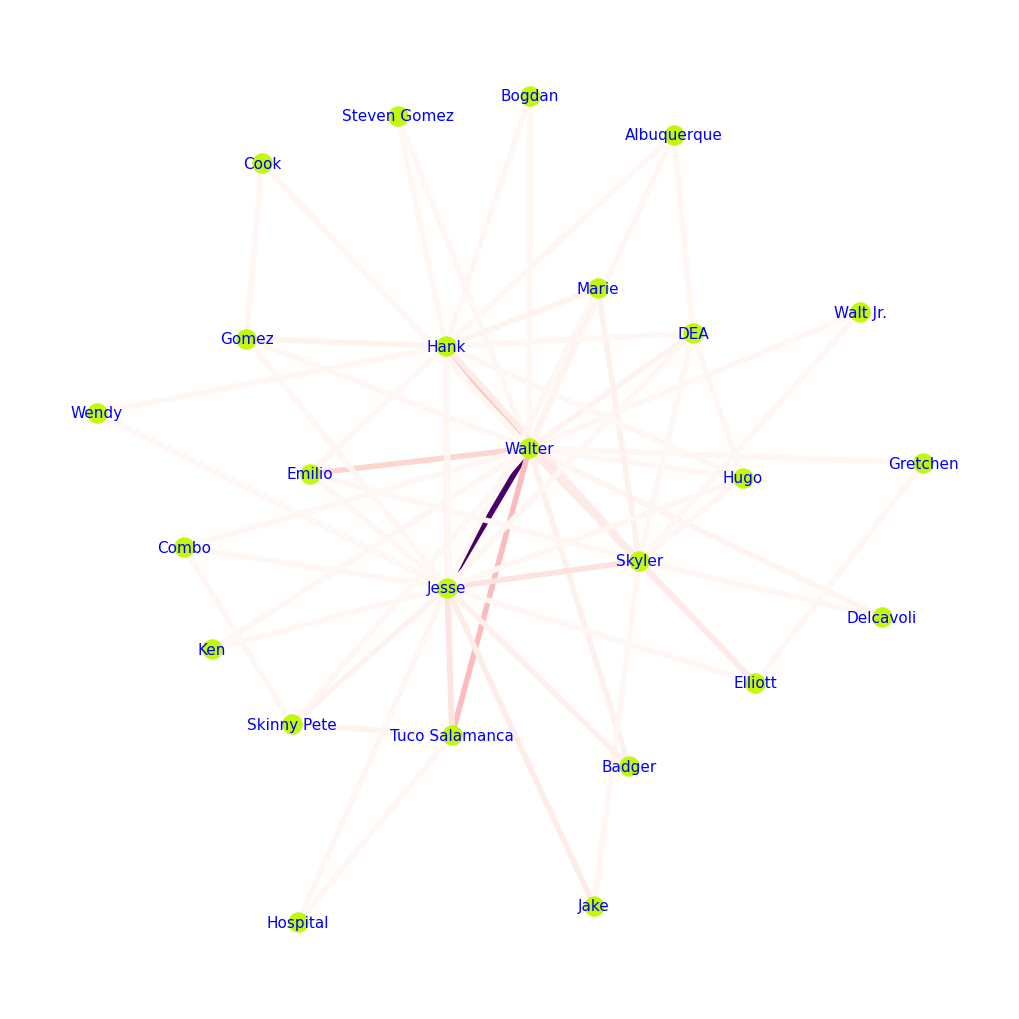

In [21]:
# https://stackoverflow.com/a/22971333
   
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)

Weights =  nx.get_edge_attributes(G, 'value').values()

arggs = {
        'with_labels' : 'True',
        'node_size' : 200,
        'node_color' : '#C2F906',
        'edge_color' : Weights, 
        "edge_cmap": plt.cm.RdPu,
        'width' : 4,
        'font_size' : 11,
        'font_color' : 'blue'
        }

nx.draw(G, pos = pos, **arggs)
plt.show()

# 4. Community Detection using [python-louvain](http://python-louvain.readthedocs.io/) 

In [22]:
import community.community_louvain as cl
partition = cl.best_partition(G)
nx.set_node_attributes(G, partition, 'group')

print(f"Type of 'partition' :: {type(partition)}\n\n{partition}") 

Type of 'partition' :: <class 'dict'>

{'Walter': 0, 'Albuquerque': 1, 'Skyler': 0, 'Walt Jr.': 0, 'Hank': 1, 'DEA': 1, 'Marie': 0, 'Bogdan': 1, 'Steven Gomez': 1, 'Gomez': 2, 'Cook': 2, 'Jesse': 3, 'Emilio': 0, 'Wendy': 3, 'Combo': 3, 'Skinny Pete': 3, 'Ken': 3, 'Jake': 3, 'Delcavoli': 0, 'Badger': 3, 'Elliott': 0, 'Gretchen': 0, 'Hugo': 1, 'Tuco Salamanca': 3, 'Hospital': 3}


In [23]:
# net = Network(notebook = True, width = '950px', height = '800px', bgcolor = '#222222', font_color = 'white')
# net = Network(notebook = True, width = '1300px', height = '950px', bgcolor = 'white', font_color = 'black')

# net.from_nx(G, )
# # net.save_graph('src/htmls/S01_Communities.html')
# net.show('src/htmls/S01_Communities.html')



# 5. Helper Functions for all seasons analysis

In [24]:
def generate_spacy_tokens(filename):
    
    '''
    Takes file name as input and return a spaCy NER object
    
    To see first 500 words as NER, comment out the code.
     
    Input : 
      - string : filename of the summary file
    Return :
      - spaCy NER object
    '''
    
    with open(filename, 'r') as f:
        summary = f.read()
        
    summary = summary.replace('\n', '\n. ')
    
    summary = NER(summary)
    
    # displacy.render(summary[:500], style = 'ent', jupyter = True)
    
    return summary

In [25]:
def generate_entity_datafrane(summary):
    
    '''
    This function extracts NER entities from spaCy summary text
    and return a pandas dataframe with columns as text and list of entities.
    
    To see first 5 rows of the returning dataframe, comment out the code.
    
    Input : 
      - string : spaCy summary file
    Return :
      - pandas dataframe : entity_df
    '''
    
    entity_df = []

    for sentence in summary.sents:
        entity_lis = [ent.text for ent in sentence.ents]
        entity_df.append({'sentence' : sentence, 'entities' : entity_lis})

    entity_df = pd.DataFrame(entity_df)
    
    # display(entity_df.head().style.set_caption('entity_df').set_table_styles(styles))
    
    return entity_df

In [26]:
def clean_entity_df(df, char_df):
    
    '''
    This funtion takes entity_df and character_df as input and filters the entity_df values based on character_df.
    Extracts only character names and stores in new column of entity_df.
    A pandas dataframe is returned where there is atleast one entry in the newly created column.
    
    To see first 5 rows of the returning dataframe, comment out the code.
    
    Input : 
      - pandas dataframe : entity_df
      - pandas dataframe : character_df
    Return :
      - pandas dataframe : processed entity_df
    '''
    
    df['char_entities'] = df.entities.apply(lambda x: filter_entities(x, char_df))
    df = df[df['char_entities'].map(len) > 0]
    df.reset_index(inplace = True, drop = True)
    
    # display(df.head().style.set_caption('cleaned entity_df').set_table_styles(styles))
    
    return df

In [27]:
def generate_relationships(df):
    
    '''
    This function takes entity_df as input and iterates through whole the rows.
    We are taking a window_size and listing all the entries in that window and stores it as 'char_list'.
    From this listed 'char_list' we generates relationship and stores it as 'relationship'.
    A pandas dataframe is generating using this 'relationship' and return.
    
    Example on generating relationships :
    -------------------------------------
    char_list   = ['Walter', 'Jesse', 'Walter', 'Jesse', 'Walter', 'Walter', 'Jesse', 'Gomez', 'Hank', 'Walter', 'Walter']
    unique_char = ['Walter', 'Jesse', 'Walter', 'Jesse', 'Walter', 'Jesse', 'Gomez', 'Hank', 'Walter']
    
    In this exapmle in 'char_list', item 5 & 6, are same. So skipping similar items like this.
    Otherwise considering 1st item as 'source' and 2nd item as 'destination'.
    
    Input : 
      - pandas dataframe : entity_df
    Return :
      - pandas dataframe : relationship_df
    '''
    
    relationship = []
    window_size  = 5
    
    for idx in range(df.shape[0]):
        e_idx = min(idx+window_size, df.shape[0])
        char_list = sum(df.loc[idx:e_idx].char_entities, [])

        char_list = list(map(name_correction, char_list))

        unique_char = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]
        
        if len(unique_char) > 1:
            for idx, a in enumerate(unique_char[:-1]):
                b = unique_char[idx + 1]
                relationship.append({'Source' : a, 'Destination' : b})
                
    return pd.DataFrame(relationship)

In [28]:
def generate_graph_weights(df):
    
    '''
    Takes the 'relationship_df' as input and using pandas groupby funtion to count
    the number of occurance and stores in it in new coulcoulm 'value' and return the same dataframe.
    This 'value' will help us in identifying importance of the edges.
    
    To see first 5 rows of the returning dataframe, comment out the code.
    
    Input : 
      - pandas dataframe : relationship_df
    Return :
      - pandas dataframe : processed relationship_df
    '''
    
    df['value'] = 1
    df = df.groupby(['Source', 'Destination'], sort=False, as_index=False).sum()
    
    # display(df.head(10).style.set_caption('WT_relationship_df').set_table_styles(styles))
    
    return df

In [29]:
def generate_map(filename):
    
    '''
    Takes file name as input and processes functions,
        1. generate_spacy_tokens()
        2. generate_entity_datafrane()
        3. clean_entity_df()
        4. generate_relationships()
        5. generate_graph_weights()
        
    Using 'generate_graph_weights' functions creating a 'networkx' grapg object and returns it.
    
    To see first 5 rows of the 'relationship_df' dataframe, comment out the appropriate code.
    To see shape of 'relationship_df' dataframe, comment out the appropriate code.
    
    To see first 5 rows of the 'processed relationship_df' dataframe, comment out the appropriate code.
    To see shape of 'processed relationship_df' dataframe, comment out the appropriate code.
    
    Input : 
      - string : path to the summary file
    Return :
      - pandas dataframe : networkx graph object
    '''
    
    summary = generate_spacy_tokens(filename)
    
    entity_df = generate_entity_datafrane(summary)
    
    entity_df = clean_entity_df(entity_df, character_df)
    
    relationship_df = generate_relationships(entity_df)
    
    # display(relationship_df.head(10).style.set_caption('relationship_df').set_table_styles(styles))
    
    # print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")
    
    relationship_df = generate_graph_weights(relationship_df)
    
    # display(relationship_df.head(10).style.set_caption('processed relationship_df').set_table_styles(styles))
    
    # print(f"Shape of dataset 'relationship_df' :: {relationship_df.shape}\n")
    
    return nx.from_pandas_edgelist(relationship_df, source = 'Source', target = 'Destination', edge_attr = 'value', create_using = nx.Graph())

In [30]:
import community.community_louvain as cl
def community_plot(graph_object, season):
    
    '''
    This function takes a graph object and season name as input.
    Using 'community_louvain' generates communites and using this ploting
    community network with the help of pyvis' module.
    
    Inputs :
      - networkx graph object : 
      - string : name of the season
    Returns :
      - Saves and shows the generated pyvis community network plot
    '''
    
    partition = cl.best_partition(graph_object)
    
    nx.set_node_attributes(graph_object, partition, 'group')
    
    net = Network(notebook = True, width = '1300px', height = '950px', bgcolor = 'white', font_color = 'black')
    
    net.repulsion(node_distance = 200) # Helped to reduce the vibration of the nodes.
    
    net.from_nx(graph_object)
    
    return net.show(f'src/htmls/{season}_Communities.html')

In [31]:
# https://stackoverflow.com/a/10035974
# https://engineeringfordatascience.com/posts/matplotlib_subplots/

def plot_centrality(graph_object, season):
    
    '''
    This function takes a graph object and season name as input.
    Using different centrality measures, obtaining top 5 node characters
    and their centrality values to generate bar plot.
    
    Different Centrality measures we are using,
        1. Degree Centrality
        2. Closeness Centrality
        3. Betweenness Centrality
        4. EigenVector Centrality

    Inputs :
      - networkx graph object : 
      - string : name of the season
    Returns :
      - None : Only saves plots generated to mentioned dirctory
    '''
    
    nx_centralities = [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality, nx.eigenvector_centrality]
    centralities = ['Degree', 'Closeness', 'Betweenness', 'EigenVector']
    
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 12))
    plt.subplots_adjust(hspace = 0.3)
    
    fig.suptitle(f'{season} : Character importance', y = 0.95)
    
    axs = axs.ravel()
    
    for idx, (title, nx_graph) in enumerate(zip(centralities, nx_centralities)):
        
        top_5_chars = dict(sorted(nx_graph(graph_object).items(), key = lambda x : x[1], reverse = True)[:5])
        
        sns.barplot(x = list(top_5_chars.keys()), y = list(top_5_chars.values()), ax = axs[idx])
        
        axs[idx].set_title(f'Based on : {title} centrality')
        axs[idx].tick_params(axis = 'x', labelrotation = 10)
        
    plt.savefig(f'src/plots/{season}_char_imp.svg', bbox_inches = 'tight', pad_inches = 0.3)
    
    plt.show()

# 6. Generate `networkx` graph objects for all seasons

In [32]:
# Obtaining all the summary file path

summaries = sorted(glob.glob('data/summaries/Season*.txt'), reverse = False)

In [33]:
# For stylizing dataframes

styles = [dict(selector='caption', props=[('text-align', 'center'), ('font-size', '150%'), ('color', '#FFFFFF'), ('background-color' , '#6DA3C7')])] 

In [34]:
# Generating networkx's graph objects for all the summaries present

map_dict = {}

for season in summaries:
    key = season.split('/')[-1]
    key = key.split('.')[0]
    # print(key)
    map_dict[key] = generate_map(season)
    
map_dict

{'Season_1': <networkx.classes.graph.Graph at 0x17f5bbb10>,
 'Season_2': <networkx.classes.graph.Graph at 0x2abd94110>,
 'Season_3': <networkx.classes.graph.Graph at 0x108061790>,
 'Season_4': <networkx.classes.graph.Graph at 0x16e763750>,
 'Season_5A': <networkx.classes.graph.Graph at 0x2abdda310>,
 'Season_5B': <networkx.classes.graph.Graph at 0x2abbbc850>}

# 7. Network Analysis and Interpretation



- Centrality measures are a vital tool for understanding networks, often also known as graphs.
- These algorithms use graph theory to calculate the importance of any given node in a network.
- They cut through noisy data, revealing parts of the network that need attention – but they all work differently.
- Each measure has its own definition of ‘importance’.

Reference : [Cambridge Intelligence](https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/)

<img src = 'src/imgs/Centrality.png' width = 90% >

## 7.1 Degree Centrality

- *Definition :* Degree centrality assigns an importance score based simply on the number of links held by each node.
- *What it tells us :* How many direct, ‘one hop’ connections each node has to other nodes in the network.
- *When to use it :* For finding very connected  individuals, popular individuals, individuals who are likely to hold  most information or individuals who can quickly connect with the wider  network.
- Degree centrality is the simplest measure of node connectivity. Sometimes it’s useful to look at  in-degree (number of inbound links) and out-degree (number of outbound  links) as distinct measures, for example when looking at transactional  data or account activity.

## 7.2 Betweenness centrality

- *Definition :* Betweenness centrality measures the number of times a node lies on the shortest path between other nodes.
- *What it tells us :* This measure shows which nodes are ‘bridges’ between nodes in a network. It does this by identifying all  the shortest paths and then counting how many times each node falls on  one.
- *When to use it :* For finding the individuals who influence the flow around a system.
- Betweenness is useful for  analyzing communication dynamics, but should be used with care. A high  betweenness count could indicate someone holds authority over disparate  clusters in a network, or just that they are on the periphery of both  clusters.

## 7.3 Closeness centrality

- *Definition :* Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network.
- *What it tells us :* This measure calculates the  shortest paths between all nodes, then assigns each node a score based  on its sum of shortest paths.
- *When to use it :* For finding the individuals who are best placed to influence the entire network most quickly.
- Closeness centrality can help  find good ‘broadcasters’, but in a highly-connected network, you will  often find all nodes have a similar score. What may be more useful is  using Closeness to find influencers in a single cluster.

## 7.4 EigenCentrality

- *Definition :* Like degree centrality, EigenCentrality  measures a node’s influence based on the number of links it has to other nodes in the network. EigenCentrality then goes a step further by also  taking into account how well connected a node is, and how many links  their connections have, and so on through the network.
- *What it tells us :* By calculating the extended  connections of a node, EigenCentrality can identify nodes with influence over the whole network, not just those directly connected to it.
- *When to use it :* EigenCentrality is a good  ‘all-round’ SNA score, handy for understanding human social networks,  but also for understanding networks like malware propagation.
- Our tools calculate each node’s EigenCentrality by converging on an eigenvector using the power iteration method.

## 7.5 PageRank

- *Definition :* PageRank is a variant of  EigenCentrality, also assigning nodes a score based on their  connections, and their connections’ connections. The difference is that  PageRank also takes link direction and weight into account – so links  can only pass influence in one direction, and pass different amounts of  influence.
- *What it tells us :* This measure uncovers nodes whose influence extends beyond their direct connections into the wider network.
- *When to use it :* Because it takes into account  direction and connection weight, PageRank can be helpful for  understanding citations and authority.
- PageRank is famously one of the ranking algorithms behind the original Google  search engine (the ‘Page’ part of its name comes from creator and Google founder, Larry Page).

# 8. **Season 1**  : Finding communities and important characters

In [35]:
community_plot(map_dict['Season_1'], 'Season_1')

src/htmls/Season_1_Communities.html


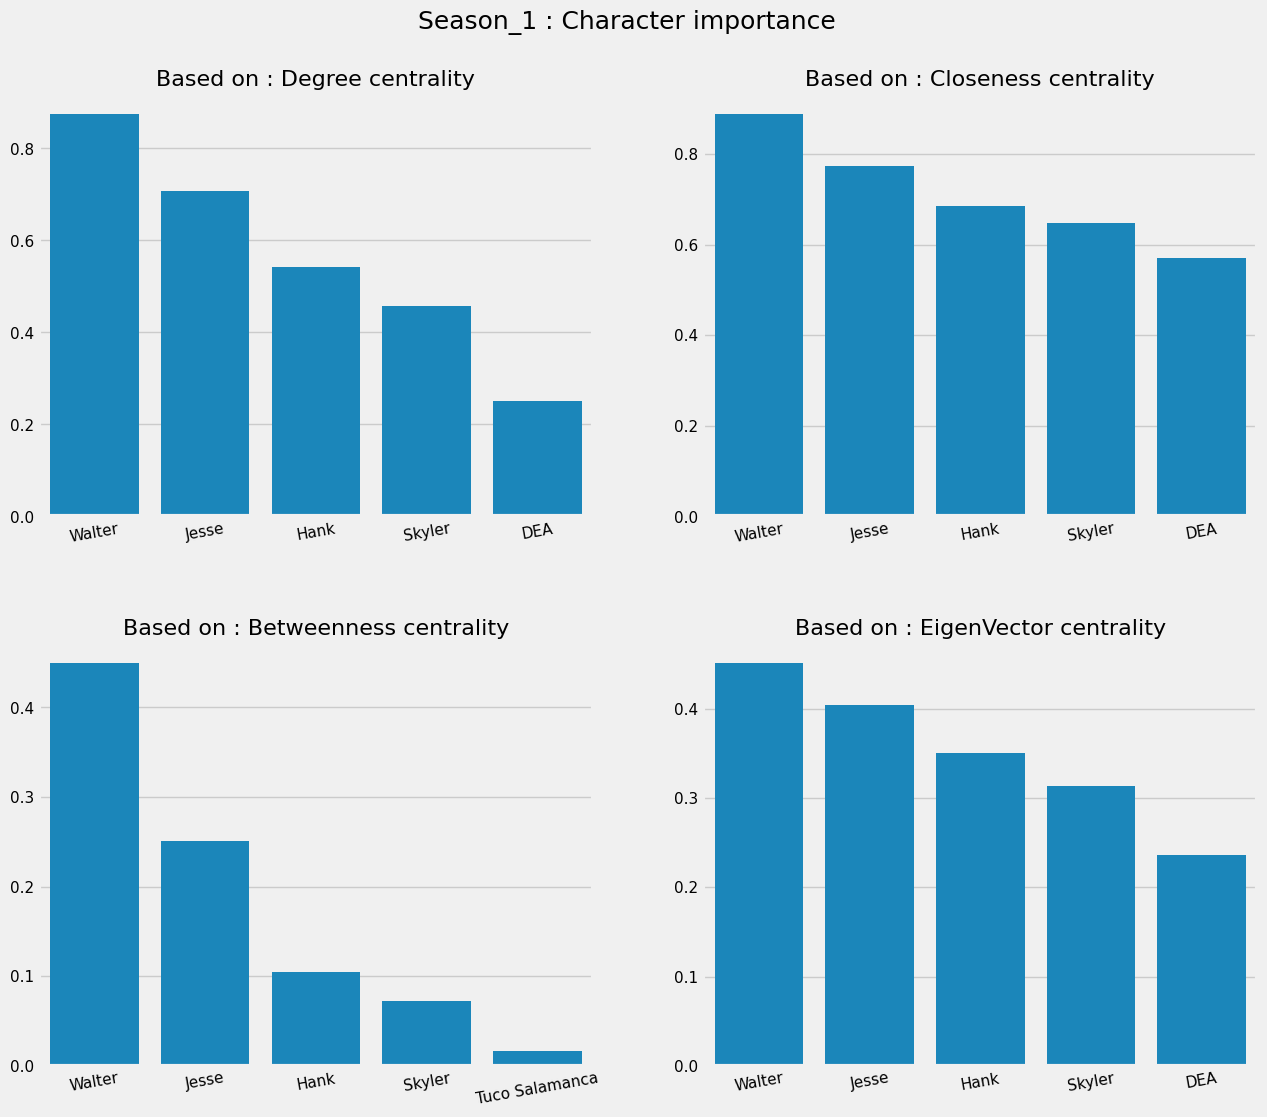

In [36]:
plot_centrality(map_dict['Season_1'], 'Season_1')

# 9. **Season 2**  : Finding communities and important characters

In [37]:
community_plot(map_dict['Season_2'], 'Season_2')

src/htmls/Season_2_Communities.html


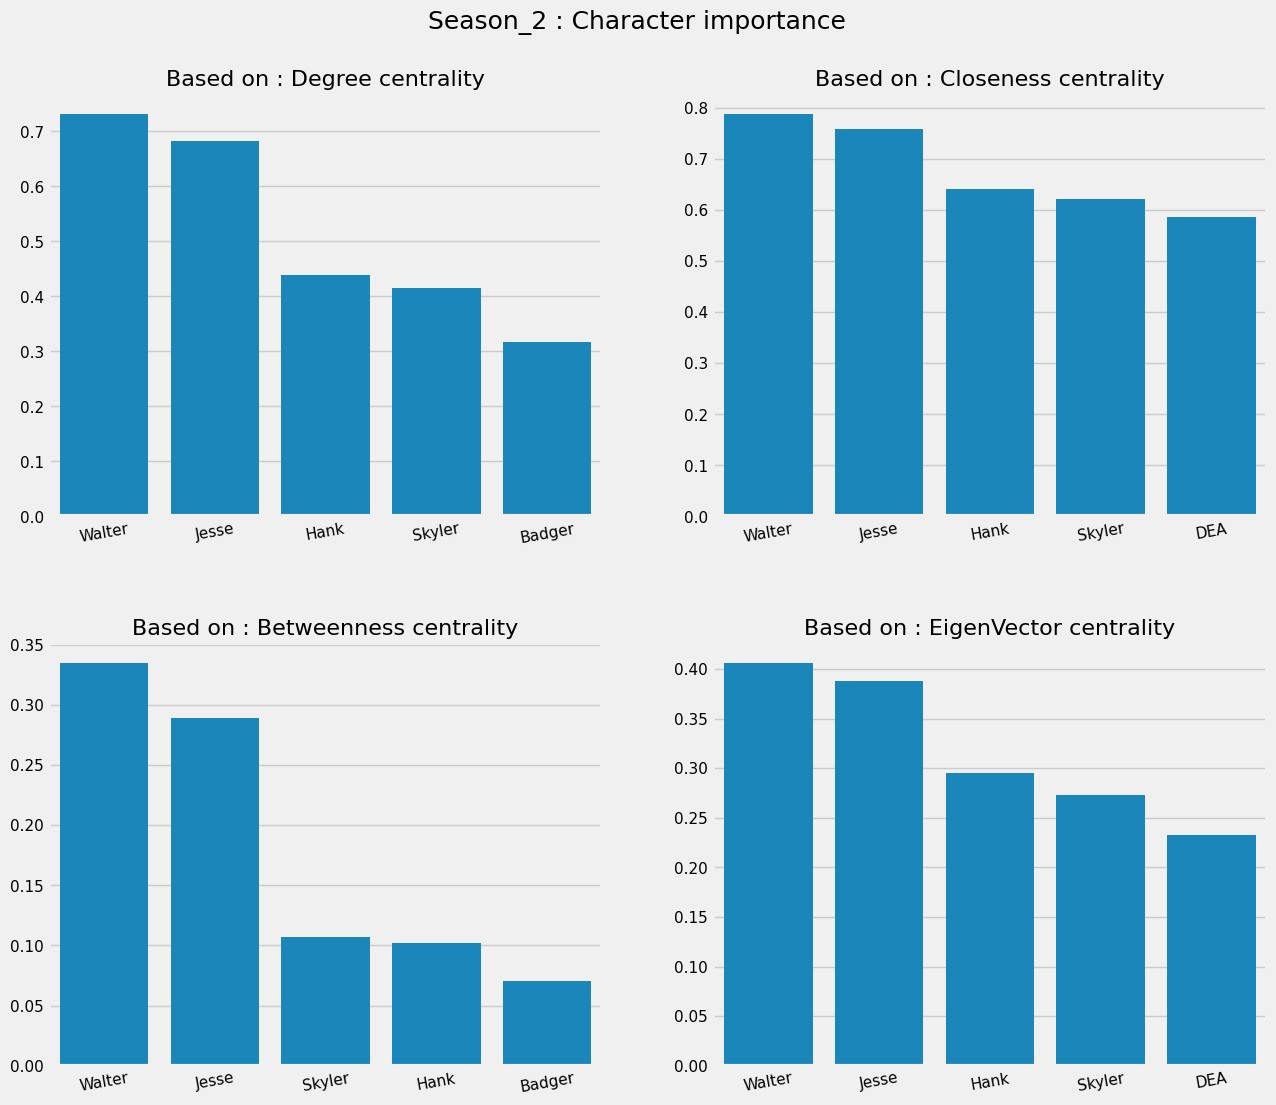

In [38]:
plot_centrality(map_dict['Season_2'], 'Season_2')

# 10. **Season 3**  : Finding communities and important characters

In [39]:
community_plot(map_dict['Season_3'], 'Season_3')

src/htmls/Season_3_Communities.html


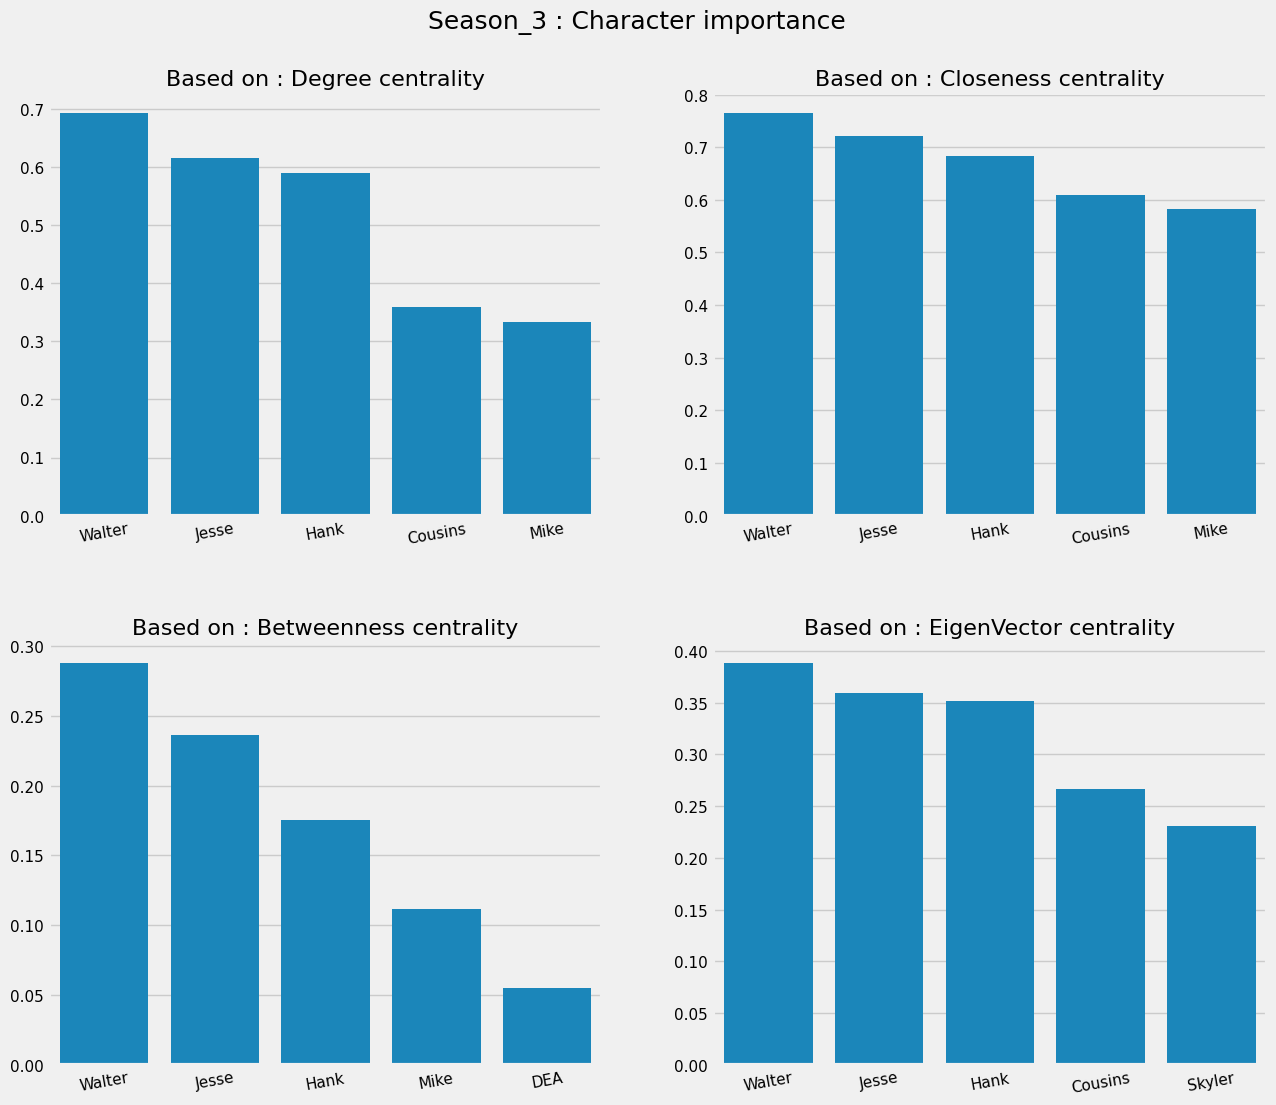

In [40]:
plot_centrality(map_dict['Season_3'], 'Season_3')

# 11. **Season 4**  : Finding communities and important characters

In [41]:
community_plot(map_dict['Season_4'], 'Season_4')

src/htmls/Season_4_Communities.html


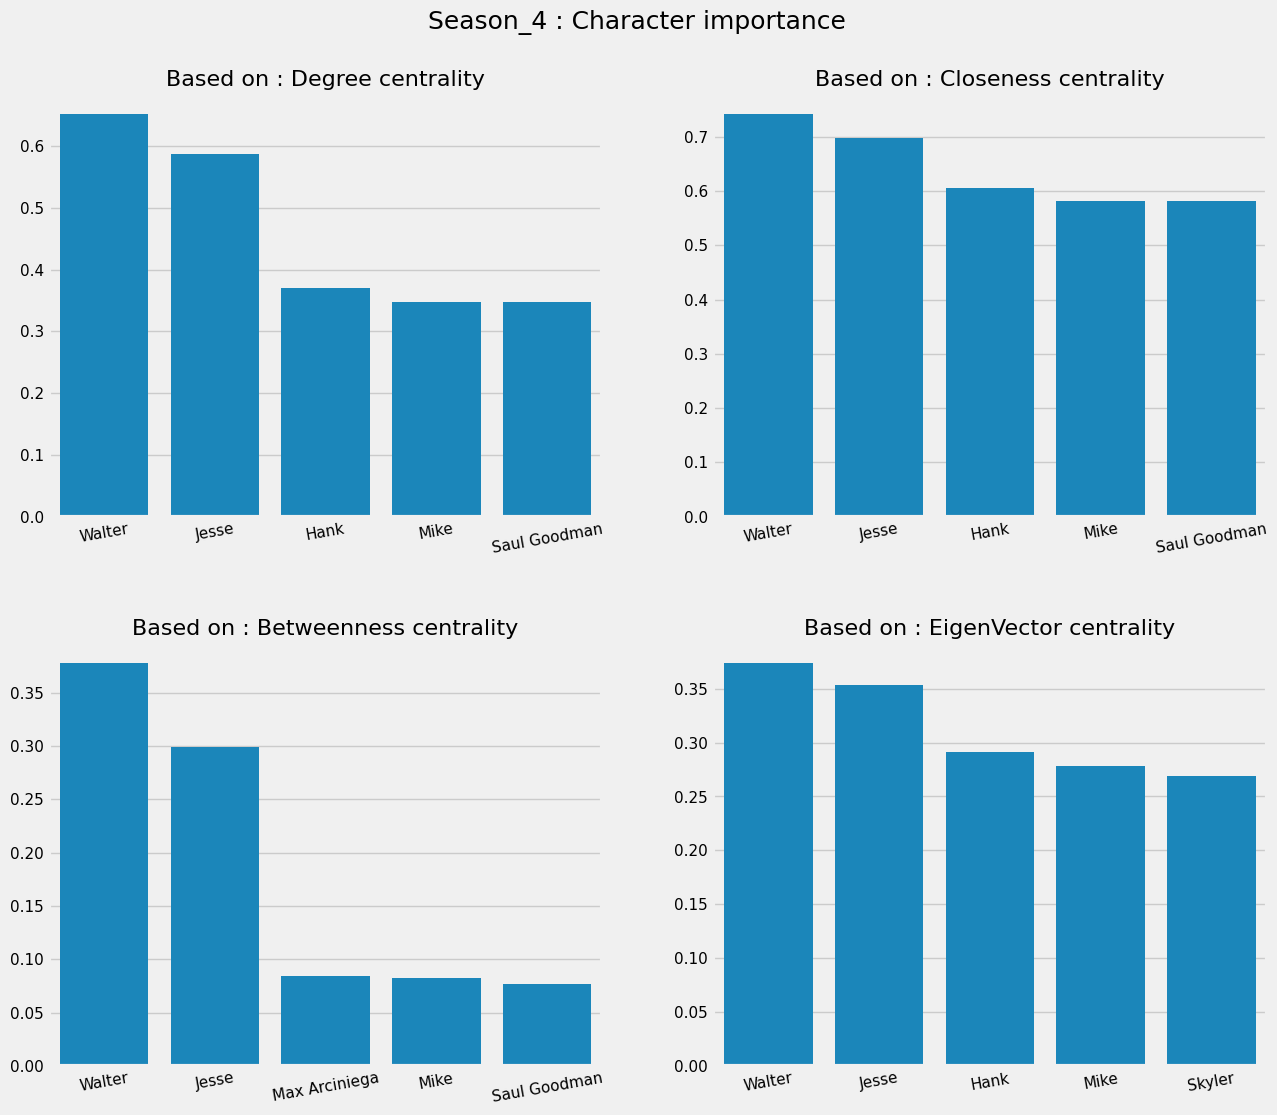

In [42]:
plot_centrality(map_dict['Season_4'], 'Season_4')

# 12. **Season 5A**  : Finding communities and important characters

In [43]:
community_plot(map_dict['Season_5A'], 'Season_5A')

src/htmls/Season_5A_Communities.html


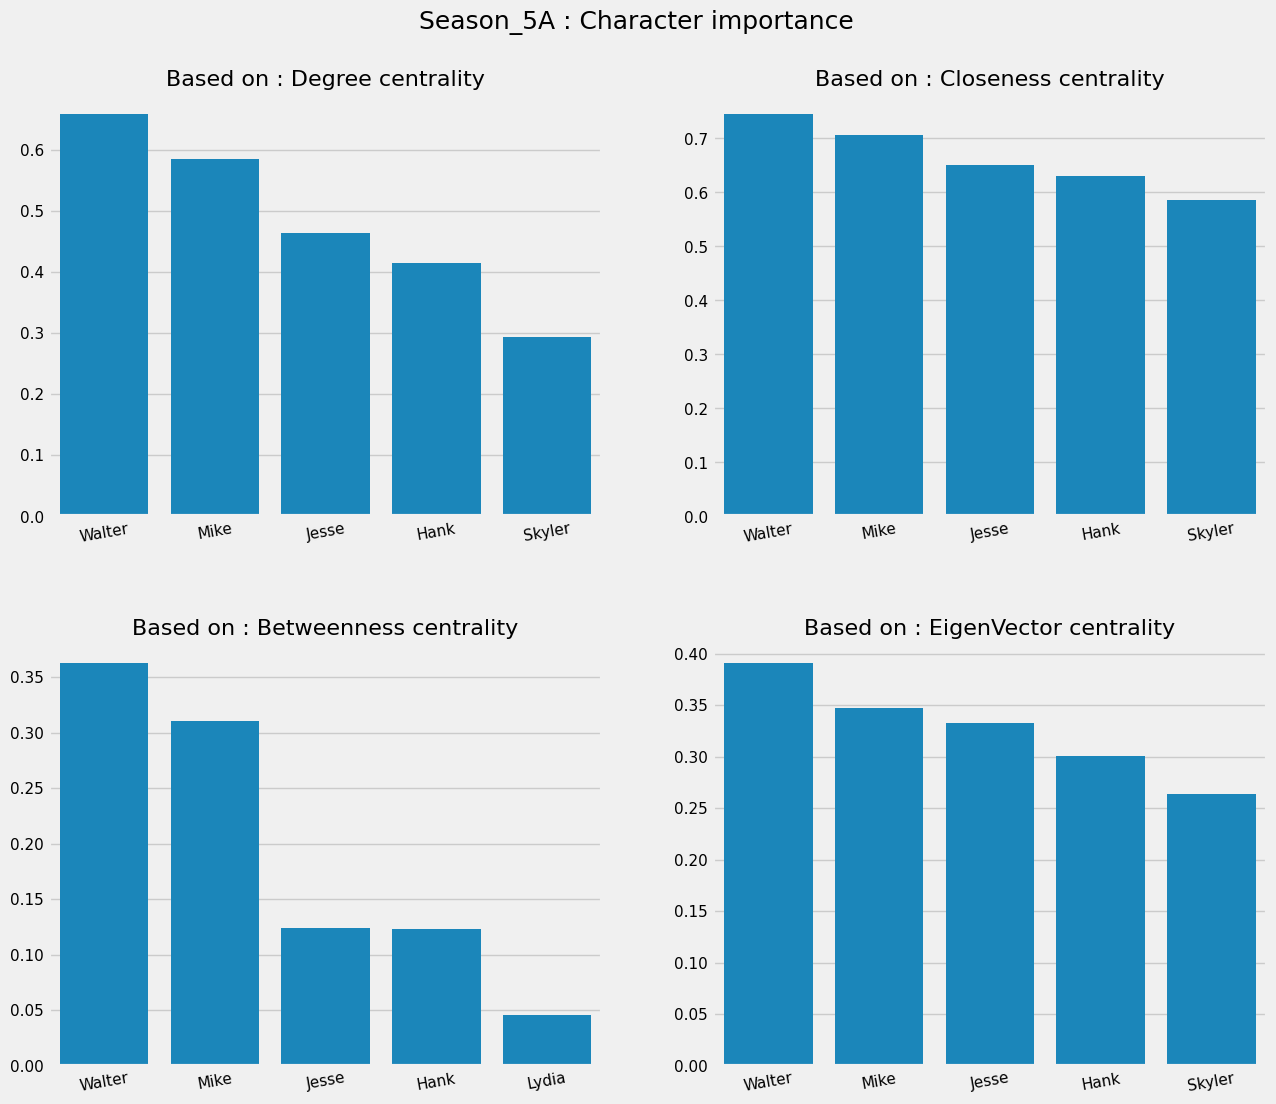

In [44]:
plot_centrality(map_dict['Season_5A'], 'Season_5A')

# 13. **Season 5B**  : Finding communities and important characters

In [45]:
community_plot(map_dict['Season_5B'], 'Season_5B')

src/htmls/Season_5B_Communities.html


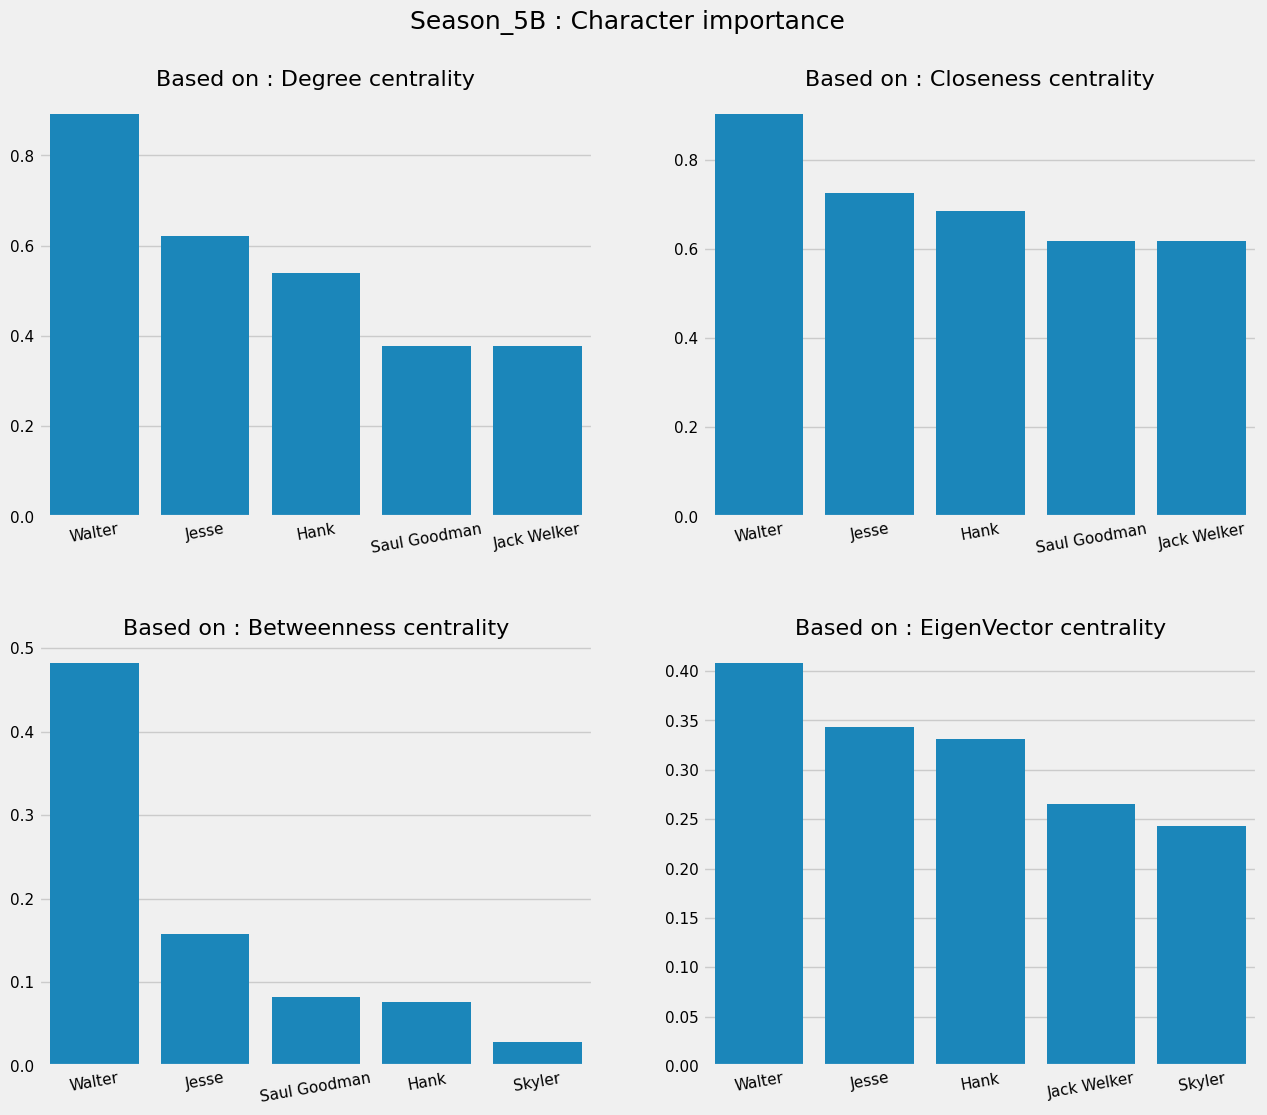

In [46]:
plot_centrality(map_dict['Season_5B'], 'Season_5B')

# 14. **Whole series**  : Finding communities and important characters

In [47]:
# Combining all the season wise summaries to one file

combined_summary_path = 'data/summaries/combined_summaries.txt'

with open(combined_summary_path, 'w') as combined:
    for season in summaries:
        with open(season, 'r') as summary:
            combined.writelines(summary.read())

In [48]:
# Generating graph object for combined text data file

combined_map = generate_map(combined_summary_path)

In [52]:
community_plot(combined_map, 'Combined')

src/htmls/Combined_Communities.html


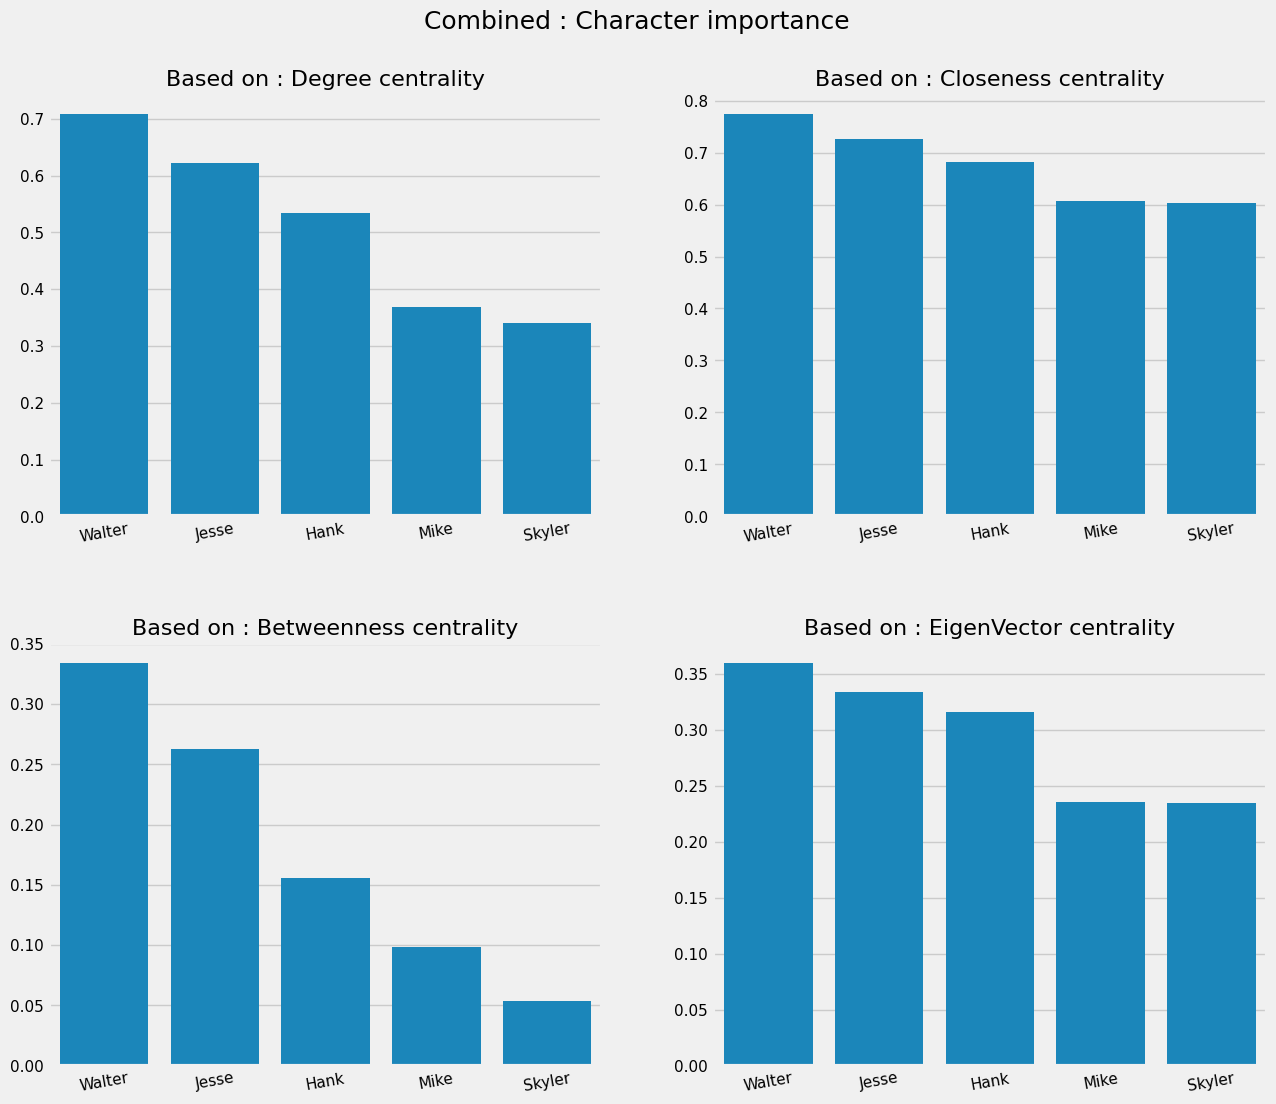

In [53]:
plot_centrality(combined_map, 'Combined')

# 15. Evolution of importance of characters over the series

In [56]:
# https://plotly.com/python/static-image-export/



def character_Importence(centrality, title_):
    
    '''
    Takes networkx centrality object function and a sting for plot title.
    Iterated through all the seasons networkx_graph object and generates centrality score, 
    on this takes top 5 node characters with the centrality scores.
    Using this record of 5 top nodes of each season ploting a line plot using 'Plotly' module.
    
    Input :
      - networkx centrality object : centrality
      - sting : title_
    Return :
      - None : Only plots the lineplot and saves it to the metioned directory.
    '''
    
    set_of_char = set()
    file_name = 'src/char_imp/' + title_ + '.svg'
    title_ = ' '.join(title_.split('_')).title()
    
    if title_ != 'betweenness_centrality' :
        evolution = [centrality(map_) for season, map_ in map_dict.items()]
    else:
        evolution = [centrality(map_, weight = 'value') for season, map_ in map_dict.items()]
    evolution_df  = pd.DataFrame(evolution)
    evolution_df.index = list(map_dict.keys())
    
    for idx in range(evolution_df.shape[0]):
        
         set_of_char.update(evolution_df.iloc[idx].sort_values(ascending = False)[:5].index) 
            
    set_of_char = list(set_of_char)

    evolution_df = pd.melt(evolution_df[set_of_char].reset_index().fillna(0), id_vars = 'index', var_name = 'Char_Name', value_name = 'Centrality_Score')
    
    fig = px.line(evolution_df, x = 'index', y = 'Centrality_Score', color = 'Char_Name', height = 500, width = 1000, labels = {'Centrality_Score' : f'{title_} Score', 'index' : ''})
    fig.update_layout(
        {'title' : 
             {'text' : f'Character Importance : {title_}', 'x' : 0.5},
         'hovermode' : 'x'
         # 'hovermode' : 'x unified' # For different style hover data information
        })
    fig.update_traces(
        {'mode' : 'markers + lines',
         'hovertemplate' : None
        })
    
    fig.write_image(file_name)
    fig.show()

## 15.1 Closeness Centrality

In [57]:
character_Importence(nx.closeness_centrality, 'closeness_centrality')

## 15.2 Betweenness Centrality

In [58]:
character_Importence(nx.betweenness_centrality, 'betweenness_centrality')

## 15.3 Eigenvector Centrality

In [59]:
character_Importence(nx.eigenvector_centrality, 'eigenvector_centrality')

# 16. What does Google PageRank tell us about BreakingBad?

In [60]:
character_Importence(nx.pagerank, 'pagerank')

# 17. Correlation between different measures

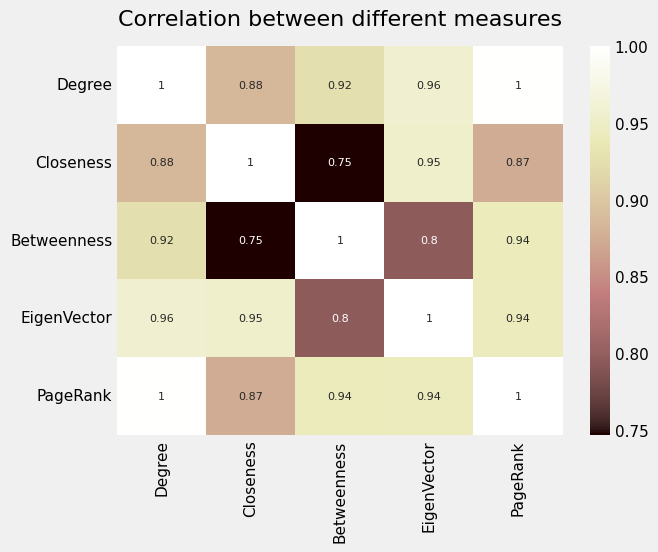

In [61]:
# https://stackoverflow.com/a/56243909

all_measures = [nx.degree_centrality(combined_map), nx.closeness_centrality(combined_map), nx.betweenness_centrality(combined_map, weight='weight'), nx.eigenvector_centrality(combined_map), nx.pagerank(combined_map)]
idx_name = ['Degree', 'Closeness', 'Betweenness', 'EigenVector', 'PageRank']

cor = pd.DataFrame(all_measures)
cor.index = idx_name
sns.heatmap(cor.T.corr(), annot = True, annot_kws = {'size' : 8}, cmap = plt.get_cmap('pink')) # pink, afmhot
plt.title('Correlation between different measures', pad = 15)
plt.show()

- This shows **PageRank** and **Degree** aare highly correlated or they are similar.
- **Betweenness** and **Closeness** are the lowest correlated one present, but still have a correlatoin on 0.74.

# 18. Exporting edge list for [Gephi](https://gephi.org/) network visualization

In [62]:
def csv_for_gephi(graph_obj, name_):
    
    '''
    Gephi is a open-source network visualization tool. To work with Gephi, we can use CSV files.
    Using networkx's 'to_pandas_edgelist' funtion we can extract all the present graph graph infromations.
    Combining this with 'graph's' node data we will have enough data for our Gephi needs.
    
    Input :
      - networkx graph object :graph_obj
      - string : name_
    Return :
      - None : Only saves CSV files at it's desired loactions
    '''
    
    edge_list_df = nx.to_pandas_edgelist(graph_obj).rename(columns = {'value' : 'weight'}).drop('width', axis = 1)
    node_df = pd.DataFrame(dict(graph_obj.nodes)).T.reset_index().rename(columns = {'index' : 'source'}).drop('size', axis = 1)
    final_df = pd.merge(edge_list_df, node_df, on = 'source').rename(columns = {'group' : 'community'})
    final_df.to_csv(f'data/gephi_files/{name_}.csv', index = False)

In [63]:
# Adding 'combined_map' object to map_dict dictionary and generaing CSV's for Gephi

map_dict['Combined'] = combined_map

for season, map_ in map_dict.items():
    csv_for_gephi(map_, season)

## Gephi visualization over series

<img src = 'src/imgs/combined_summary_gephi.svg' width = 75%>

# 19. Conclution : Most important character

In [64]:
deg_cent, col_cent, bet_cent, eig_cent, pag_rank = cor.idxmax(axis=1)

print('Meaasure Based on:\tCharacter')
print('-' * 33)
print(f'Degree Centrality\t: {deg_cent}')
print(f'Closeness Centrality\t: {col_cent}')
print(f'Betweenness Centrality\t: {bet_cent}')
print(f'EigenVector Centrality\t: {eig_cent}')
print(f'PageRank\t\t: {pag_rank}')

Meaasure Based on:	Character
---------------------------------
Degree Centrality	: Walter
Closeness Centrality	: Walter
Betweenness Centrality	: Walter
EigenVector Centrality	: Walter
PageRank		: Walter


All the centrality measures giving a unique name. This clearly shows Walter aka **Walter White** is the most important character among all the seasons in this series **Breaking Bad** Not a surpise, huh? 

<!-- # 20. Next Is What?

<img src = 'src/imgs/Breaking_Bad_Franchise.jpeg' width = 90% >

## [Breaking Bad (franchise)](https://en.wikipedia.org/wiki/Breaking_Bad_(franchise))

Breaking Bad is a neo-Western crime drama franchise created by American filmmaker Vince Gilligan, primarily based on the 2008–2013 television series **Breaking Bad**, its 2015–2022 prequel/sequel series **Better Call Saul**, the former's 2019 sequel film **El Camino: A Breaking Bad Movie**, and the latter's 2022 prequel animated series **Slippin' Jimmy**.

1. #### [Breaking Bad (2008–2013)](https://en.wikipedia.org/wiki/Breaking_Bad)
    - Breaking Bad revolves around chemistry teacher turned-methamphetamine drug lord Walter White and his former student and fellow cook/dealer Jesse Pinkman.

2. #### [Better Call Saul (2015–2022)](https://en.wikipedia.org/wiki/Better_Call_Saul)
    - Better Call Saul follows criminal lawyer Jimmy McGill / Saul Goodman whom Walter and Jesse eventually hire.
    - It is a spin-off of previous series, Breaking Bad, and serves as a prequel and sequel to its predecessor.

3. #### [El Camino: A Breaking Bad Movie (2019)](https://en.wikipedia.org/wiki/El_Camino:_A_Breaking_Bad_Movie)
    - El Camino: A Breaking Bad Movie focuses on Jesse after the events of the series.
    - It serves as a sequel and epilogue to the television series Breaking Bad.
    - It continues the story of Jesse Pinkman, who partnered with former teacher Walter White throughout the series to build a crystal meth empire based in Albuquerque.

4. #### [Better Call Saul Presents: Slippin' Jimmy (2022)](https://en.wikipedia.org/wiki/Slippin%27_Jimmy)
    - Better Call Saul Presents: Slippin' Jimmy, more commonly known as Slippin' Jimmy, is an American animated web series and a spin-off of Better Call Saul (itself a spin-off of Breaking Bad) -->

## Now what ?

- **A**t present we only scrapped and analyzed [Breaking Bad](https://en.wikipedia.org/wiki/Breaking_Bad)'s data.
- There are rooms available to perform same kind of operations to get more insight to the franchise.
- We can scrape and analyze each series alone to see the important characters in each series.
- Once we have all the summary data of **Breaking Bad**, **Better Call Saul**, **El Camino** and **Slippin' Jimmy**, now combine all the data generate more insight of the franchise.

# References

References
- Official documentations of all libraries
- [Wikipedia](https://www.wikipedia.org/)
- [Cambridge Intelligence](https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/)
- [DataCamp - A Network Analysis of Game of Thrones](https://www.datacamp.com/projects/76)
- Chapter 3 - Network Structure and Measures : [Analyzing the Social Web by Jennifer Golbeck](https://www.sciencedirect.com/book/9780124055315/analyzing-the-social-web)
- [Translating Networks: Assessing Correspondence Between Network Visualisation and Analytics](https://hal.archives-ouvertes.fr/halshs-02179024/)

Query Resolution
- [GeeksforGeeks](https://www.geeksforgeeks.org/)
- [Stack Overflow](https://stackoverflow.com/)
- [Engineering for Data Science](https://engineeringfordatascience.com/posts/matplotlib_subplots/)
    
Image Credits
- [pijamasurf.com](pijamasurf.com)
- [usmagazine.com](usmagazine.com)